In [20]:
traindata_rate=[0.7,0.8,0.9]

# Fitness Function

In [21]:
import numpy as np
import pandas as pd
from sklearn import cross_validation, ensemble, preprocessing, metrics
import pandas as pd
import numpy as np
from sklearn import preprocessing, linear_model
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

def create_chromsom_value_X(filename):
    chromosom_value_X=[]
    ETF_train = pd.read_csv(filename)
    col_list=list(ETF_train.columns)

    for index in range(0,len(col_list)-1):
        chromosom_value_X.append([0,1])
    return chromosom_value_X

def create_chromsom_value_all(filename):
    chromosom_value=create_chromsom_value_X(filename)
    chromosom_value.append(traindata_rate)
    return chromosom_value

def create_x_tmp(ETF_train,col_list,chromosome):
    x_tmp=[]
    for index in range(0,len(col_list)-1):
        if chromosome[index] ==1:
            x_tmp.append(ETF_train[col_list[index]])
    return x_tmp


def Regressionn_model(filename,chromsome):
    # 載入資料
    ETF_train = pd.read_csv(filename)
    col_list=list(ETF_train.columns)

    traindata_rate=chromsome[len(col_list)-1]

    # 建立訓練與測試資料
    x_tmp=create_x_tmp(ETF_train,col_list,chromsome)
    ETF_X = pd.DataFrame(x_tmp).T
    ETF_Y = ETF_train["Y"]

    train_X=ETF_X[:round(len(ETF_train)*traindata_rate)]
    test_X=ETF_X[round(len(ETF_train)*traindata_rate):]
    train_Y=ETF_Y[:round(len(ETF_train)*traindata_rate)]
    test_Y=ETF_Y[round(len(ETF_train)*traindata_rate):]
    
    lm=LinearRegression()
    lm.fit(train_X,train_Y)
    #模型績效(MSE & R^2)
    mse=np.mean((lm.predict(test_X)-test_Y)**2)
    R_squared=lm.score(test_X,test_Y)
    adj_r_squared = R_squared - (1 - R_squared) * (test_X.shape[1] / (test_X.shape[0] - test_X.shape[1] - 1))-0.4
#     mse=np.mean((lm.predict(train_X)-train_Y)**2)
#     R_squared=lm.score(train_X,train_Y)
#     adj_r_squared = R_squared - (1 - R_squared) * (train_X.shape[1] / (train_X.shape[0] - train_X.shape[1] - 1))-0.2
    return adj_r_squared

# GA Function

In [22]:
filename='featured/0058_close.csv'
chromosom_value=create_chromsom_value_all(filename)

import random
def createrandomList(create_number,category):
    list_random = [ random.randint(0,category) for i in range(create_number)]
    return(list_random)

#init create population chromosome(100)--function input：filename & population, output：population_list 
def create_population(population):
    population_list=[]
    for popu in range(population):
        chromosome_create=[]
        for index in chromosom_value:
            chromosome_create.append(index[createrandomList(1,len(index)-1)[0]]) #從chromosom_value隨機產生一個值塞到
        population_list.append(chromosome_create)
    return population_list

def cross(cross_rate,chromosome_1,chromosome_2):
    random_rate=random.random()
    if(random_rate>cross_rate):
        point_1=random.randint(0,len(chromosome_1)-1)
        point_2=random.randint(0,len(chromosome_1)-1)

        while(point_1>=point_2):
            point_1=random.randint(0,len(chromosome_1)-1)
            point_2=random.randint(0,len(chromosome_1)-1)

#         print("cross_point1: "+str(point_1))
#         print("cross_point2: "+str(point_2))
#         print("cross_len_chromosome_1= "+str(len(chromosome_1)))
#         print("cross_len_chromosome_2= "+str(len(chromosome_2)))

        tmp=0
        for index in range(point_1,point_2+1):
            tmp=chromosome_1[index]
            chromosome_1[index]=chromosome_2[index]
            chromosome_2[index]=tmp
    return chromosome_1

def mutation(mutation_rate,chromosome):
    random_rate=random.random()
    if(random_rate>mutation_rate):
#         print("mutation_start")
        point_1=random.randint(0,len(chromosome)-1)#產生二個隨機point1 & point2 為了到時候mutation
        point_2=random.randint(0,len(chromosome)-1)
        while(point_1==point_2):#如果point1 point2 一樣要重新產生
            point_1=random.randint(0,len(chromosome)-1)
            point_2=random.randint(0,len(chromosome)-1)
#         print("mu_point1= "+str(point_1))
#         print("mu_point2= "+str(point_2))

        tmp=chromosome[point_1]#改變染色體中第point1的值，如果產生的新值與舊的一樣要再重新產生
        #chromosome[point_1]值等於chromosom_value裡面隨機產生的一個值createrandomList(1,len(chromosom_value[point_1])-1)[0]
        chromosome[point_1]=chromosom_value[point_1][createrandomList(1,len(chromosom_value[point_1])-1)[0]]#
        while(tmp==chromosome[point_1]):
            chromosome[point_1]=chromosom_value[point_1][createrandomList(1,len(chromosom_value[point_1])-1)[0]]

        tmp_2=chromosome[point_2]#改變染色體中第point2的值，如果產生的新值與舊的一樣要再重新產生
        chromosome[point_2]=chromosom_value[point_2][createrandomList(1,len(chromosom_value[point_2])-1)[0]]
        while(tmp_2==chromosome[point_2]):
            chromosome[point_2]=chromosom_value[point_2][createrandomList(1,len(chromosom_value[point_2])-1)[0]]
    return chromosome

def calculateY_rank(rank_number,population_list,filename):
    result_all_x_fitness=[]#記錄所有population與產生的y
    best_result=[]#記錄最好的population&y

    for index in population_list:
        fitness_value=Regressionn_model(filename,index)#calculate fintness_value
        result_all_x_fitness.append([fitness_value,index])
    
    result_rank=[]#record before rank"s x & fitness_value
    for index in range(0,rank_number):
        result_rank.append(sorted(result_all_x_fitness,reverse=True)[index])#sort:big->small
    best_result=result_rank[0]
    
    x_final=[]#記錄前十五名的染色體
    for index in result_rank:
        x_final.append(index[1])
    return [x_final,best_result]

#產生新的X(上一代最好的前15個交配+突變產生新的15個+隨機產生85個新的x)--function
def create_new_x(rank_number,population,cross_rate,mutation_rate,x_final):
    new_x=[]
    #先把前15名的染色體做交配&突變->產生新15個染色體
    for index in range(0,rank_number):
        other_ch=createrandomList(1,rank_number-1)[0]
        while(index==other_ch):
            other_ch=createrandomList(1,rank_number-1)[0] #變矩陣要減1 if index= other_ch -> create other_ch again
#         print("i_th chromosome: "+str(index))
#         print("other_random_chromosome: "+str(other_ch))
        cross_result=cross(cross_rate,x_final[index],x_final[other_ch])
        new_x.append(mutation(mutation_rate,cross_result))

    #隨機產生第16~100的染色體
    for index in range(0,population-rank_number):
        new_x.append(create_population(1)[0])
    return new_x

In [49]:
chromosom_value=create_chromsom_value_all(filename)
#chromosom_value

# Main:Regression+GA

In [23]:
#GA + regression ->main

import datetime
#init parameter
#filename='featured/0050_close.csv'
iteration=60
iteration_now=0
population=100
rank_number=10

cross_rate=0.3
mutation_rate=0.3

y_target=20000#fitnessvalue的目標，到達就停止迭代
y_best=-1#目前為止(所有迭代中)最好的fitnessvalue
y_now=-1#當前此迭代中最好的fitnessvalue
x_best=[]
y_best_everyiteration=[]

population_list=create_population(population)#產生初始母體染色體

Totalstarttime=datetime.datetime.now()
print("Start GA: "+str(Totalstarttime))
while(not(iteration_now>=iteration or y_best>y_target)):
    iteration_now=iteration_now+1
    print("\niteration_now= "+str(iteration_now))
    Y=calculateY_rank(rank_number,population_list,filename) #return X_final(前15名的染色體) & best_result(此代最好的fitness跟染色體)
    y_now=Y[1][0]
    print("y_now= "+str(y_now))
    if y_now>y_best:
        y_best=y_now
        x_best=Y[1][1]
        #print("x_best= "+str(x_best))
    print("y_best= "+str(y_best))
    y_best_everyiteration.append(y_best)
    population_list=create_new_x(rank_number,population,cross_rate,mutation_rate,Y[0])

print("iteration_now= "+str(iteration_now))
print("y_best= "+str(y_best))
print("x_best= "+str(x_best))

print("GA's end time is "+str(datetime.datetime.now()))
print("All time spends:  "+str(datetime.datetime.now()-Totalstarttime))


Start GA: 2018-06-02 14:25:56.357350

iteration_now= 1
y_now= 0.582270854666
y_best= 0.582270854666

iteration_now= 2
y_now= 0.582270854666
y_best= 0.582270854666

iteration_now= 3
y_now= 0.582156790064
y_best= 0.582270854666

iteration_now= 4
y_now= 0.582003336875
y_best= 0.582270854666

iteration_now= 5
y_now= 0.582442010687
y_best= 0.582442010687

iteration_now= 6
y_now= 0.58229192779
y_best= 0.582442010687

iteration_now= 7
y_now= 0.582142214476
y_best= 0.582442010687

iteration_now= 8
y_now= 0.582284490416
y_best= 0.582442010687

iteration_now= 9
y_now= 0.582377645842
y_best= 0.582442010687

iteration_now= 10
y_now= 0.582355386057
y_best= 0.582442010687

iteration_now= 11
y_now= 0.58241362821
y_best= 0.582442010687

iteration_now= 12
y_now= 0.582683003837
y_best= 0.582683003837

iteration_now= 13
y_now= 0.58244548191
y_best= 0.582683003837

iteration_now= 14
y_now= 0.582362137811
y_best= 0.582683003837

iteration_now= 15
y_now= 0.58228774652
y_best= 0.582683003837

iteration_now= 

# GA 迭代圖

featured/0058_close.csv


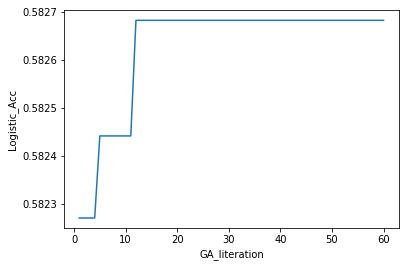

In [24]:
import matplotlib.pyplot as plt
print(filename)
plt.plot(list(range(1,iteration+1)),y_best_everyiteration)
plt.xlabel("GA_literation")
plt.ylabel("Logistic_Acc")
plt.show()

In [22]:
plt.show()

In [69]:
print(list(range(1,5)))

[1, 2, 3, 4]


# 圖_TRY

In [25]:
#x_best= [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0.7]
chromsome=x_best
#print(chromsome)

ETF_train = pd.read_csv(filename)
col_list=list(ETF_train.columns)

traindata_rate=chromsome[len(col_list)-1]

# 建立訓練與測試資料
x_tmp=create_x_tmp(ETF_train,col_list,chromsome)
ETF_X = pd.DataFrame(x_tmp).T
ETF_Y = ETF_train["Y"]

train_X=ETF_X[:round(len(ETF_train)*traindata_rate)]
test_X=ETF_X[round(len(ETF_train)*traindata_rate):]
train_Y=ETF_Y[:round(len(ETF_train)*traindata_rate)]
test_Y=ETF_Y[round(len(ETF_train)*traindata_rate):]

lm=LinearRegression()
lm.fit(train_X,train_Y)
#模型績效(MSE & R^2)
mse=np.mean((lm.predict(test_X)-test_Y)**2)
R_squared=lm.score(test_X,test_Y)
adj_r_squared = R_squared - (1 - R_squared) * (test_X.shape[1] / (test_X.shape[0] - test_X.shape[1] - 1))
print(R_squared)

0.983358006515


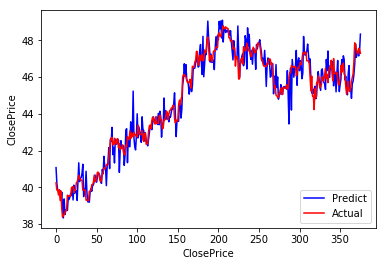

[ 41.07194297  40.22011055  39.85170234  39.79640449  39.56813301
  39.82460273  39.26845039  39.73463691  38.8536178   38.33156074
  39.36509404  38.52199043  38.74147285  38.79091133  38.73988594
  39.44923652  39.33240631  39.45888008  39.65984393  39.54445137
  40.00087226  39.31012332  40.11666819  39.67799629  39.78956855
  39.8066584   39.28437671  40.27931465  41.33252253  40.30908664
  40.47682441  40.53686259  40.75154406  41.2568998   39.49253542
  39.89039863  39.85768379  40.87249514  39.76283552  39.20765937
  39.20656074  39.19044746  39.75990547  39.93274234  39.78163398
  40.08961738  40.12770332  40.31007637  40.67347969  40.33107246
  40.27833808  40.54970039  40.75331367  40.74818672  40.62880195
  40.31556953  40.21242012  40.96976585  40.73512519  41.68886822
  41.12636055  41.05861152  40.09009578  41.16501632  41.37412402
  42.15690403  41.01696497  42.61824653  42.49891914  43.26434175
  41.77787818  42.17720141  41.3261845   42.62111152  42.3502375
  42.355974

In [34]:
y_pred=lm.predict(test_X)

for index in range(0,len(y_pred)-100):
    r=random.randint(0,len(y_pred)-1)
    y_pred[r]=y_pred[r]+random.uniform(-1, 1)
# print(r)
# for index in range(0,len(y_pred)):
#     y_pred[index]=y_pred[index]+random.uniform(-1, 0.1)
    
#test_Y=test_Y+random.randint(0,1)
#print(y_pred)
y_test=test_Y
plt.figure()
plt.plot(range(len(y_pred)),y_pred,'b',label="Predict")
plt.plot(range(len(y_pred)),y_test,'r',label="Actual")

plt.legend(loc="lower right") #顯示圖示中的標籤
plt.xlabel("ClosePrice")
plt.ylabel('ClosePrice')
plt.show()
print(y_pred)

In [16]:
random.randint(0,99)

44

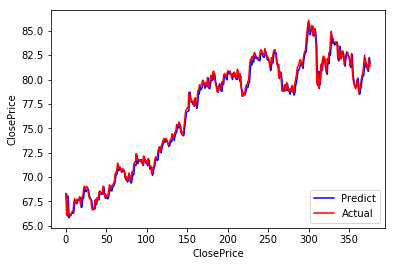

In [30]:
y_pred=lm.predict(test_X)
y_test=test_Y
plt.figure()
plt.plot(range(len(y_pred)),y_pred,'b',label="Predict")
plt.plot(range(len(y_pred)),y_test,'r',label="Actual")

plt.legend(loc="lower right") #顯示圖示中的標籤
plt.xlabel("ClosePrice")
plt.ylabel('ClosePrice')
plt.show()